#Bristish Airways Reviews Analysis
This notebook details the process of scraping customer reviews for British Airways from AirlineQuality.com, followed by cleaning, structuring the collected data, and Exploratory Data Analysis.

##1. Importing of Libraries and Setup
First, we import the necessary Python libraries for web scraping (requests, BeautifulSoup), data manipulation (pandas), file handling (json), logging, regular expressions (re), time management, and displaying DataFrames nicely in Jupyter (IPython.display).

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time
import re
import logging
from IPython.display import display

base_url = "https://www.airlinequality.com/airline-reviews/british-airways/"
max_pages = 1000 # Maximum pages to scrape
raw_data = "raw_reviews.json"
cleaned_data = "cleaned_reviews.csv"

##2. Scraping
The following code defines a function scrape_page to fetch and parse reviews from a single page on AirlineQuality.com. It extracts details like the review title, author/country, rating, review body, verification status, and structured data from the review table (e.g., seat type, aircraft, service ratings).

We then loop through a defined number of pages, calling scrape_page for each and adding the results to a list.

Finally, the raw scraped data is saved to a JSON file (raw_reviews.json).

In [2]:
def scrape_page(page_num):
    """Scrapes a single page of reviews."""
    url = f"{base_url}page/{page_num}/"
    logging.info(f"Scraping page: {url}")
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes
        soup = BeautifulSoup(response.content, 'html.parser')
        reviews = soup.find_all('article', itemprop='review')
        page_reviews = []

        if not reviews:
            logging.warning(f"No reviews found on page {page_num}.")
            return None # Signal end of reviews

        for review in reviews:
            data = {'page': page_num}
            try:
                data['title'] = review.find('h2', class_='text_header').text.strip() if review.find('h2', class_='text_header') else None
                data['author_country'] = review.find('h3', class_='text_sub_header').text.strip() if review.find('h3', class_='text_sub_header') else None
                rating_tag = review.find('span', itemprop='ratingValue')
                data['rating_out_of_10'] = int(rating_tag.text.strip()) if rating_tag and rating_tag.text.strip().isdigit() else None

                review_body_tag = review.find('div', class_='text_content', itemprop='reviewBody')
                if review_body_tag:
                    # Extract verification status and review text
                    verification_tag = review_body_tag.find('strong')
                    if verification_tag:
                        data['verification_status'] = verification_tag.text.strip()
                        # Remove the verification part from the main text
                        verification_tag.decompose()
                    else:
                        data['verification_status'] = None
                    data['review_body'] = review_body_tag.text.strip()
                else:
                    data['verification_status'] = None
                    data['review_body'] = None

                # Extract table data
                ratings_table = review.find('table', class_='review-ratings')
                if ratings_table:
                    for row in ratings_table.find_all('tr'):
                        header = row.find('td', class_='review-rating-header')
                        value = row.find('td', class_='review-value')
                        stars = row.find('td', class_='review-rating-stars')

                        if header and (value or stars):
                            header_text = header.text.strip().lower().replace(' ', '_')
                            if stars and stars.find_all('span', class_='star fill'):
                                data[f'{header_text}_rating'] = len(stars.find_all('span', class_='star fill'))
                            elif value:
                                data[header_text] = value.text.strip()

                page_reviews.append(data)
            except Exception as e:
                logging.error(f"Error parsing a review on page {page_num}: {e}")
                continue # Skip this review if parsing fails

        return page_reviews

    except requests.exceptions.RequestException as e:
        logging.error(f"Error fetching page {page_num}: {e}")
        return [] # Return empty list on fetch error
    except Exception as e:
        logging.error(f"An unexpected error occurred while scraping page {page_num}: {e}")
        return []

def main():
    all_reviews = []
    for i in range(1, max_pages + 1):
        reviews_on_page = scrape_page(i)
        if reviews_on_page is None: # Stop if no reviews found (likely end of pages)
            logging.info(f"Stopping scrape at page {i} as no reviews were found.")
            break
        all_reviews.extend(reviews_on_page)
        time.sleep(1) # Be polite and wait a second between requests

    if not all_reviews:
        logging.error("No reviews were scraped. Exiting.")
        return

    output_file = 'raw_reviews.json'
    logging.info(f"Scraping complete. Found {len(all_reviews)} reviews across {max_pages} pages (or fewer if pages ran out).")
    logging.info(f"Saving raw data to {output_file}")

    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(all_reviews, f, ensure_ascii=False, indent=4)
        logging.info("Raw data saved successfully.")
    except IOError as e:
        logging.error(f"Error saving data to JSON file: {e}")

if __name__ == "__main__":
    main()

In [3]:
# Main scraping loop
all_reviews = []
print(f"Starting scrape for up to {max_pages} pages...") # Use print in notebook
for i in range(1, max_pages + 1):
    print(f"Scraping page {i}...")
    reviews_on_page = scrape_page(i)
    if reviews_on_page is None: # Stop if no reviews found
        print(f"Stopping scrape at page {i} as no reviews were found.")
        break
    if reviews_on_page: # Ensure list is not empty before extending
        all_reviews.extend(reviews_on_page)
    time.sleep(1) # Pause between page requests

if not all_reviews:
    print("Error: No reviews were scraped.") # Use print
else:
    print(f"Scraping complete. Found {len(all_reviews)} reviews.") # Use print
    print(f"Saving raw data to {raw_data}") # Use print
    try:
        with open(raw_data, "w", encoding="utf-8") as f:
            json.dump(all_reviews, f, ensure_ascii=False, indent=4)
        print("Raw data saved successfully.") # Use print
    except IOError as e:
        print(f"Error saving data to JSON file: {e}") # Use print

Starting scrape for up to 1000 pages...
Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping 

Stopping scrape at page 396 as no reviews were found.
Scraping complete. Found 3941 reviews.
Saving raw data to raw_reviews.json
Raw data saved successfully.


In [4]:
df = pd.DataFrame(all_reviews)
print(df.head())
print(df.describe())
print(df.info())

   page                                     title  \
0     1                     "legroom was limited"   
1     1               "our bags took a long time"   
2     1  “flight crew was welcoming and friendly”   
3     1           "high level of professionalism"   
4     1                      “Horrendous Service”   

                             author_country  rating_out_of_10  \
0  Michael Little (Australia) 20th May 2025               6.0   
1  J Tydeman (United Kingdom) 18th May 2025               4.0   
2    A Norton (United States) 15th May 2025               8.0   
3   Ramona Gehri (Switzerland) 8th May 2025              10.0   
4    R Heale (South Africa) 29th April 2025               3.0   

  verification_status                                        review_body  \
0       Trip Verified  ✅  |   Check-in was slow with only one staff m...   
1        Not Verified  |  Check in was smooth enough. Boarding was ch...   
2       Trip Verified  ✅  | Although transferring to this flig

In [5]:
df.isnull().sum()

,0
page,0
title,0
author_country,0
rating_out_of_10,5
verification_status,1519
review_body,0
aircraft,1884
type_of_traveller,771
seat_type,2
route,776


In [6]:
def clean_data(input_file, output_file):
    """Loads raw JSON data, cleans it, and saves to CSV."""
    logging.info(f"Loading raw data from {input_file}")
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        logging.info(f"Loaded {len(df)} reviews into DataFrame.")
    except FileNotFoundError:
        logging.error(f"Error: Input file not found at {input_file}")
        return
    except json.JSONDecodeError:
        logging.error(f"Error: Could not decode JSON from {input_file}")
        return
    except Exception as e:
        logging.error(f"An unexpected error occurred during file loading: {e}")
        return

    logging.info("Starting data cleaning process...")

    # 1. Handle Author/Country/Date
    def extract_author_country_date(text):
        if not text or not isinstance(text, str):
            return None, None, None
        # Regex to capture Author (optional), Country, and Date
        # Allows for formats like "A Miles (United Kingdom) 30th April 2025" or "(Canada) 1st May 2025"
        match = re.match(r'(?:(.*)\s)?\((.*?)\)\s+(.*)', text)
        if match:
            author = match.group(1).strip() if match.group(1) else None
            country = match.group(2).strip()
            date_str = match.group(3).strip()
            return author, country, date_str
        else:
            # Handle cases where the format might be different or only country/date is present
            # Example: "(United Kingdom) 29th April 2025"
            match_no_author = re.match(r'\((.*?)\)\s+(.*)', text)
            if match_no_author:
                 country = match_no_author.group(1).strip()
                 date_str = match_no_author.group(2).strip()
                 return None, country, date_str
            else:
                logging.warning(f"Could not parse author/country/date from: {text}")
                return None, None, None

    extracted_info = df['author_country'].apply(extract_author_country_date)
    df['author'] = extracted_info.apply(lambda x: x[0] if x else None)
    df['country'] = extracted_info.apply(lambda x: x[1] if x else None)
    df['date_str'] = extracted_info.apply(lambda x: x[2] if x else None)
    # Attempt conversion to datetime, coerce errors to NaT (Not a Time)
    # Need to handle 'st', 'nd', 'rd', 'th' in day numbers
    df['date_str_cleaned'] = df['date_str'].str.replace(r'(\d+)(st|nd|rd|th)', r'\1', regex=True)
    df['date'] = pd.to_datetime(df['date_str_cleaned'], format='%d %B %Y', errors='coerce') # Specify format

    # 2. Clean Review Body and Title
    df['review_body'] = df['review_body'].str.strip()
    df['title'] = df['title'].str.strip()

    # 3. Clean Verification Status
    # Example: "| Trip Verified", "| Not Verified"
    df['verification_status'] = df['verification_status'].str.replace('|', '', regex=False).str.strip()
    df['verified_trip'] = df['verification_status'].str.contains('Trip Verified', na=False)

    # 4. Standardize Ratings (convert numeric ratings to numeric type)
    rating_cols = [col for col in df.columns if '_rating' in col and col != 'rating_out_of_10']
    df['rating_out_of_10'] = pd.to_numeric(df['rating_out_of_10'], errors='coerce')
    for col in rating_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 5. Clean Text Columns from Table (like aircraft, type_of_traveller, etc.)
    text_table_cols = ['aircraft', 'type_of_traveller', 'seat_type', 'route', 'date_flown', 'recommended']
    for col in text_table_cols:
        if col in df.columns:
            df[col] = df[col].str.strip()
            if col == 'recommended': # Convert Yes/No to boolean
                df['recommended'] = df[col].str.lower().map({'yes': True, 'no': False})
                # Keep NaN for missing values instead of defaulting to False

    # 6. Select and Reorder Columns
    final_columns = [
        'date', 'author', 'country', 'title', 'review_body', 'rating_out_of_10',
        'aircraft', 'type_of_traveller', 'seat_type', 'route', 'date_flown',
        'seat_comfort_rating', 'cabin_staff_service_rating', 'food_&_beverages_rating',
        'inflight_entertainment_rating', 'ground_service_rating', 'wifi_&_connectivity_rating',
        'value_for_money_rating', 'recommended', 'verified_trip', 'verification_status', 'page',
        'date_str' # Keep original date string for reference if needed
    ]
    # Keep only columns that actually exist in the DataFrame
    final_columns = [col for col in final_columns if col in df.columns]
    df_cleaned = df[final_columns]

    logging.info("Data cleaning finished.")

    # 7. Save Cleaned Data
    logging.info(f"Saving cleaned data to {output_file}")
    try:
        df_cleaned.to_csv(output_file, index=False, encoding='utf-8')
        logging.info("Cleaned data saved successfully.")
    except IOError as e:
        logging.error(f"Error saving cleaned data to CSV: {e}")
    except Exception as e:
        logging.error(f"An unexpected error occurred during file saving: {e}")

if __name__ == "__main__":
    clean_data(raw_data, cleaned_data)




Graham Henrickson (Australia) 18th April 2025



J Meares (United Kingdom) 19th March 2025



Paul Mercer (United Kingdom) 7th March 2025



Paul Lee (United Kingdom) 1st February 2025



Raeesa Carrim (South Africa) 3rd January 2025



J Meares (United Kingdom) 1st January 2025



J Meares (United Kingdom) 13th December 2024



R Lane (United Kingdom) 17th November 2024



Barnaby Emmerson (United Kingdom) 3rd November 2024



Dennis Teifeld (United States) 31st October 2024



Paul Mercer (United Kingdom) 25th October 2024



Paul Mercer (United Kingdom) 12th October 2024



James Tapley (United Kingdom) 8th October 2024



Christopher Neep (United Kingdom) 28th September 2024



G Jones (Lebanon) 12th August 2024



G Jones (Lebanon) 7th August 2024



Bryan Fisk (New Zealand) 16th July 2024



R Thornton (United Kingdom) 26th June 2024



N Carter (United Kingdom) 17th June 2024



N Carter (United Kingdom) 17th June 2024



Jonathan Rodden (United Kingdom) 10th June 2024



E B

In [7]:
# Run the data cleaning function
print("Starting data cleaning process...") # Use print
clean_data(raw_data, cleaned_data)
print("Data cleaning finished.") # Use print




Graham Henrickson (Australia) 18th April 2025



J Meares (United Kingdom) 19th March 2025



Paul Mercer (United Kingdom) 7th March 2025



Paul Lee (United Kingdom) 1st February 2025



Raeesa Carrim (South Africa) 3rd January 2025



J Meares (United Kingdom) 1st January 2025



J Meares (United Kingdom) 13th December 2024



R Lane (United Kingdom) 17th November 2024



Barnaby Emmerson (United Kingdom) 3rd November 2024



Dennis Teifeld (United States) 31st October 2024



Paul Mercer (United Kingdom) 25th October 2024



Paul Mercer (United Kingdom) 12th October 2024



James Tapley (United Kingdom) 8th October 2024



Christopher Neep (United Kingdom) 28th September 2024



G Jones (Lebanon) 12th August 2024



G Jones (Lebanon) 7th August 2024



Bryan Fisk (New Zealand) 16th July 2024



R Thornton (United Kingdom) 26th June 2024



N Carter (United Kingdom) 17th June 2024



N Carter (United Kingdom) 17th June 2024



Jonathan Rodden (United Kingdom) 10th June 2024



E B

Starting data cleaning process...





Richard Hodges (United Kingdom) 17th October 2022



S Keane (United Kingdom) 14th October 2022



L Pulliam (United States) 6th October 2022



John Rolfe (United Kingdom) 1st October 2022



John Rolfe (United Kingdom) 1st October 2022



L Tran (United States) 25th September 2022



L Tran (United States) 25th September 2022



A Neale (United Kingdom) 7th September 2022



Neil Nerva (United Kingdom) 23rd August 2022



J Roberts (United Kingdom) 17th July 2022



David Lindner (United States) 27th June 2022



David Ellis (United Kingdom) 17th June 2022



Chris Walsh (United Kingdom) 8th June 2022



J Davey (United Kingdom) 27th May 2022



L Kayne (United Kingdom) 18th May 2022



G Berhler (United Kingdom) 9th May 2022



N Siotto (United Arab Emirates) 4th May 2022



Ryan Moukarram (United Kingdom) 14th April 2022



Andrew Morgan (United Kingdom) 11th April 2022



Chris Walsh (United Kingdom) 4th April 2022



Richard Hodges (United Kingdom) 4th April 2022



Richard Ho

Data cleaning finished.


In [8]:
# Load the cleaned data
try:
    # Ensure 'date' column is parsed correctly during loading
    df_cleaned = pd.read_csv(cleaned_data, parse_dates=['date'])
    print(f"Successfully loaded {cleaned_data}. Shape: {df_cleaned.shape}")
    # Display first 5 rows
    print("\nFirst 5 rows:")
    display(df_cleaned.head())
    # Display basic info
    print("\nDataFrame Info:")
    # Use display() for rich output in Jupyter
    # df_cleaned.info() prints to stdout, display() gives better format
    # Capture info() output to display it better if needed
    import io
    buffer = io.StringIO()
    df_cleaned.info(buf=buffer)
    info_str = buffer.getvalue()
    print(info_str)
    # Display summary statistics for numerical columns
    print("\nSummary Statistics:")
    display(df_cleaned.describe())
except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {cleaned_data}. \n    Please ensure the scraping and cleaning steps ran successfully before this cell.")

Successfully loaded cleaned_reviews.csv. Shape: (3941, 23)

First 5 rows:


,date,author,country,title,review_body,rating_out_of_10,aircraft,type_of_traveller,seat_type,route,...,food_&_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_&_connectivity_rating,value_for_money_rating,recommended,verified_trip,verification_status,page,date_str
0,2025-05-20,Michael Little,Australia,"""legroom was limited""",✅ | Check-in was slow with only one staff m...,6.0,A320,Couple Leisure,Economy Class,Porto to Gatwick,...,2.0,NaN,3.0,NaN,5.0,True,True,Trip Verified,1,20th May 2025
1,2025-05-18,J Tydeman,United Kingdom,"""our bags took a long time""",| Check in was smooth enough. Boarding was ch...,4.0,NaN,Couple Leisure,Economy Class,Tirana to London Heathrow,...,NaN,NaN,2.0,NaN,2.0,False,False,Not Verified,1,18th May 2025
2,2025-05-15,A Norton,United States,“flight crew was welcoming and friendly”,✅ | Although transferring to this flight thro...,8.0,Boeing 777-200,Couple Leisure,Economy Class,London Heathrow to New York JFK,...,4.0,4.0,3.0,NaN,4.0,True,True,Trip Verified,1,15th May 2025
3,2025-05-08,Ramona Gehri,Switzerland,"""high level of professionalism""",✅ | We are extremely grateful to the crew o...,10.0,NaN,Couple Leisure,Economy Class,Cape Town to London,...,3.0,5.0,5.0,5.0,5.0,True,True,Trip Verified,1,8th May 2025
4,2025-04-29,R Heale,South Africa,“Horrendous Service”,✅ | I had an appalling experience with Brit...,3.0,A380,Solo Leisure,Economy Class,Johannesburg to London Heathrow,...,NaN,NaN,1.0,NaN,1.0,False,True,Trip Verified,1,29th April 2025



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           3360 non-null   datetime64[ns]
 1   author                         3360 non-null   object        
 2   country                        3360 non-null   object        
 3   title                          3941 non-null   object        
 4   review_body                    3941 non-null   object        
 5   rating_out_of_10               3936 non-null   float64       
 6   aircraft                       2057 non-null   object        
 7   type_of_traveller              3170 non-null   object        
 8   seat_type                      3939 non-null   object        
 9   route                          3165 non-null   object        
 10  date_flown                     3163 non-null   object        
 11  

,date,rating_out_of_10,seat_comfort_rating,cabin_staff_service_rating,food_&_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_&_connectivity_rating,value_for_money_rating,page
count,3360,3936.000000,3814.000000,3799.000000,3497.000000,2677.000000,3091.000000,695.000000,3940.000000,3941.000000
mean,2018-01-05 14:17:08.571428864,4.675305,2.857892,3.231113,2.705462,2.655211,2.756066,1.939568,2.664467,197.550114
min,2011-10-09 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2015-07-21 00:00:00,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99.000000
50%,2017-02-13 00:00:00,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,198.000000
75%,2019-09-17 06:00:00,8.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,4.000000,296.000000
max,2025-05-20 00:00:00,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,395.000000
std,NaN,3.172028,1.363510,1.493631,1.437149,1.401307,1.463700,1.340707,1.468673,113.781139


# Analysis

The cleaned data (cleaned_reviews.csv) is now ready for further analysis and visualization.
Analyzing rating distributions (overall and specific categories).
Exploring trends over time.
Performing sentiment analysis on the review text.
Investigating differences based on traveller type, seat type, or route.


In [9]:
df = df_cleaned.copy()
df = df.drop(columns=['author'], axis=1)
df.head()

,date,country,title,review_body,rating_out_of_10,aircraft,type_of_traveller,seat_type,route,date_flown,...,food_&_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_&_connectivity_rating,value_for_money_rating,recommended,verified_trip,verification_status,page,date_str
0,2025-05-20,Australia,"""legroom was limited""",✅ | Check-in was slow with only one staff m...,6.0,A320,Couple Leisure,Economy Class,Porto to Gatwick,April 2025,...,2.0,NaN,3.0,NaN,5.0,True,True,Trip Verified,1,20th May 2025
1,2025-05-18,United Kingdom,"""our bags took a long time""",| Check in was smooth enough. Boarding was ch...,4.0,NaN,Couple Leisure,Economy Class,Tirana to London Heathrow,May 2025,...,NaN,NaN,2.0,NaN,2.0,False,False,Not Verified,1,18th May 2025
2,2025-05-15,United States,“flight crew was welcoming and friendly”,✅ | Although transferring to this flight thro...,8.0,Boeing 777-200,Couple Leisure,Economy Class,London Heathrow to New York JFK,May 2025,...,4.0,4.0,3.0,NaN,4.0,True,True,Trip Verified,1,15th May 2025
3,2025-05-08,Switzerland,"""high level of professionalism""",✅ | We are extremely grateful to the crew o...,10.0,NaN,Couple Leisure,Economy Class,Cape Town to London,May 2025,...,3.0,5.0,5.0,5.0,5.0,True,True,Trip Verified,1,8th May 2025
4,2025-04-29,South Africa,“Horrendous Service”,✅ | I had an appalling experience with Brit...,3.0,A380,Solo Leisure,Economy Class,Johannesburg to London Heathrow,April 2025,...,NaN,NaN,1.0,NaN,1.0,False,True,Trip Verified,1,29th April 2025


--- Overall Satisfaction Score Analysis ---
Average Overall Rating: 4.675304878048781
Distribution of Overall Ratings:
 rating_out_of_10
1.0     959
2.0     442
3.0     436
4.0     266
5.0     246
6.0     205
7.0     331
8.0     386
9.0     328
10.0    337
Name: count, dtype: int64


<ipython-input-15-f68f92d714ff>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating_out_of_10', data=df, palette='viridis')


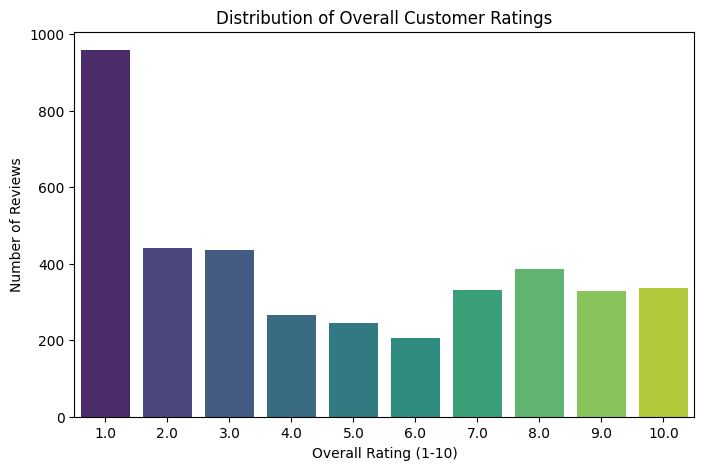

In [15]:
# Visualizing reviews by country
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob # For sentiment analysis

# plt.bar(df['country'].value_counts().index, df['country'].value_counts().values)
# plt.xlabel('Country')
# plt.ylabel('Number of Reviews')
# plt.title('Number of Reviews by Country')
# plt.xticks(rotation=90)
# plt.show()

# # Overall Trend of ratings

# plt.plot(df['date'].value_counts().sort_index())
# plt.xlabel('Date')
# plt.ylabel('Number of Reviews')
# plt.title('Number of Reviews Over Time')
# plt.show()

# --- 1. Overall Satisfaction Score ---

print("--- Overall Satisfaction Score Analysis ---")
print("Average Overall Rating:", df['rating_out_of_10'].mean())
print("Distribution of Overall Ratings:\n", df['rating_out_of_10'].value_counts().sort_index())

# Plot: Distribution of Overall Satisfaction Ratings (Bar Chart)
plt.figure(figsize=(8, 5))
sns.countplot(x='rating_out_of_10', data=df, palette='viridis')
plt.title('Distribution of Overall Customer Ratings')
plt.xlabel('Overall Rating (1-10)')
plt.ylabel('Number of Reviews')
plt.show()


--- Sentiment Analysis ---
Average Sentiment Polarity: 0.08763079096729183
Sentiment Category Distribution:
 sentiment_category
Positive    2226
Neutral      945
Negative     770
Name: count, dtype: int64


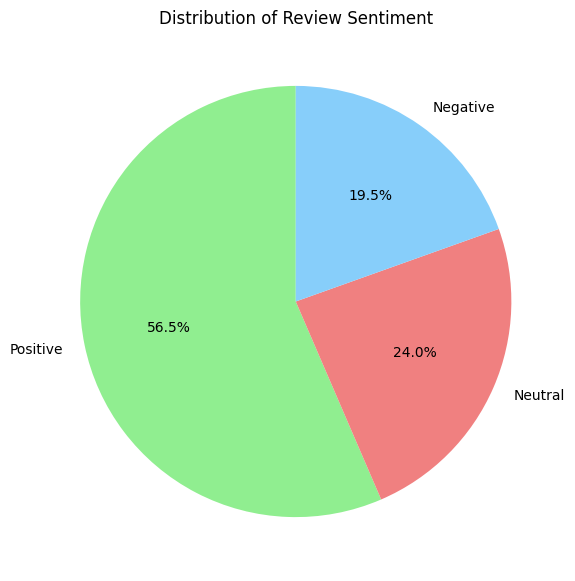

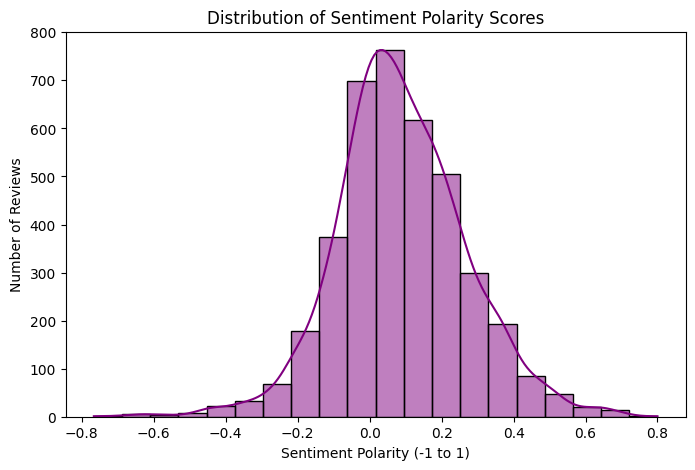

In [16]:
# --- 2. Sentiment Score (using TextBlob for simplicity) ---

# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity # -1 (negative) to 1 (positive)

df['sentiment_polarity'] = df['review_body'].apply(get_sentiment)

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_polarity'].apply(categorize_sentiment)

print("\n--- Sentiment Analysis ---")
print("Average Sentiment Polarity:", df['sentiment_polarity'].mean())
print("Sentiment Category Distribution:\n", df['sentiment_category'].value_counts())

# Plot: Sentiment Category Distribution (Pie Chart)
plt.figure(figsize=(7, 7))
df['sentiment_category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Distribution of Review Sentiment')
plt.ylabel('') # Hide the default 'sentiment_category' label
plt.show()

# Plot: Histogram of Sentiment Polarity
plt.figure(figsize=(8, 5))
sns.histplot(df['sentiment_polarity'], bins=20, kde=True, color='purple')
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity (-1 to 1)')
plt.ylabel('Number of Reviews')
plt.show()



--- Aspect-Specific Ratings Analysis ---
Average Seat Comfort: 2.86
Average Cabin Staff Service: 3.23
Average Food & Beverages: 2.71
Average Inflight Entertainment: 2.66
Average Wifi & Connectivity: 1.94
Average Ground Service: 2.76
Average Value For Money: 2.66


<ipython-input-18-dc017a4276cc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_means.values, y=aspect_means.index, palette='coolwarm')


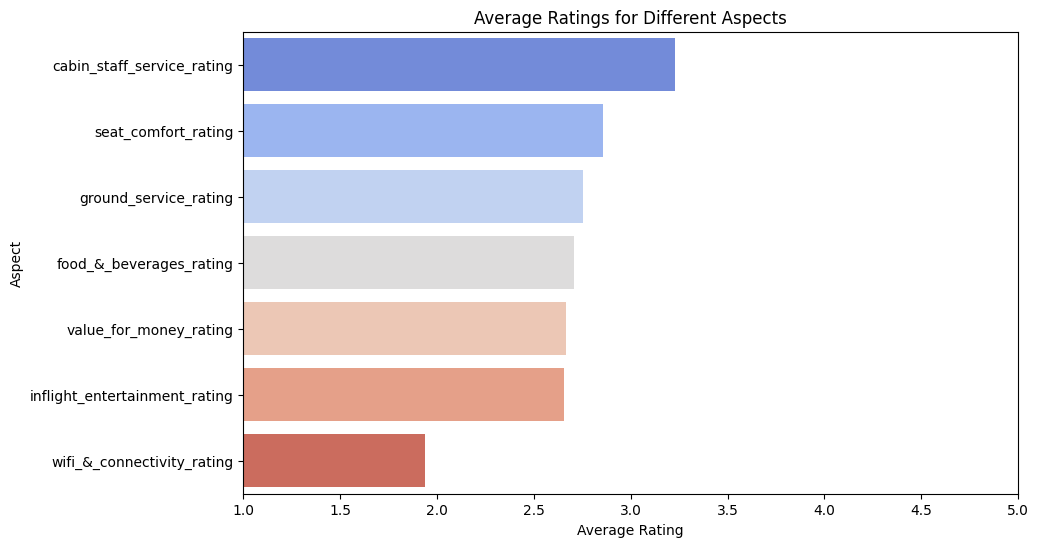

In [18]:
# --- 3. Aspect-Specific Ratings ---

# Assuming you have columns like 'seat_comfort_rating', 'food_rating' etc.
aspect_columns = ['seat_comfort_rating', 'cabin_staff_service_rating', 'food_&_beverages_rating', 'inflight_entertainment_rating','wifi_&_connectivity_rating', 'ground_service_rating', 'value_for_money_rating']

print("\n--- Aspect-Specific Ratings Analysis ---")
for aspect in aspect_columns:
    print(f"Average {aspect.replace('_rating', '').replace('_', ' ').title()}: {df[aspect].mean():.2f}")

# Plot: Average Aspect-Specific Ratings (Bar Chart)
plt.figure(figsize=(10, 6))
aspect_means = df[aspect_columns].mean().sort_values(ascending=False)
sns.barplot(x=aspect_means.values, y=aspect_means.index, palette='coolwarm')
plt.title('Average Ratings for Different Aspects')
plt.xlabel('Average Rating')
plt.ylabel('Aspect')
plt.xlim(1, 5) # Assuming 1-5 scale for ratings
plt.show()


--- Top 10 Most Frequent Words (after basic cleaning) ---
flight: 7147
service: 3010
seat: 2486
food: 2454
crew: 2304
british: 2273
london: 2248
airways: 2243
seats: 2202
good: 2198


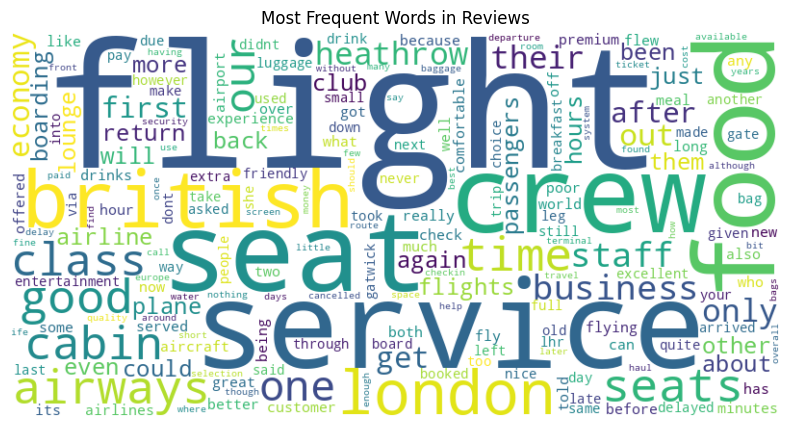

In [32]:
# --- 4. Frequency of Keywords/Topics (Basic Example) ---

# This often requires more advanced NLP (NLTK, SpaCy) for proper topic modeling.
# Here's a very basic word frequency count (after removing stop words and punctuation)
from collections import Counter
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text

df['cleaned_review_text'] = df['review_body'].apply(clean_text)

all_words = ' '.join(df['cleaned_review_text']).split()
stop_words = set(['the', 'very', 'all', 'there', 'would', 'did', 'then', 'a', 'an', 'is', 'it', 'to', 'and', 'was', 'for', 'with', 'of','which', 'than', 'are', 'when', 'you', 'from', 'i', 'my', 'me', 'not', 'but', 'this', 'were', 'they','that', 'had', 'have'])
filtered_words = [word for word in all_words if word not in stop_words and len(word) > 2] # Remove short words

word_counts = Counter(filtered_words)
top_words = word_counts.most_common(10)

print("\n--- Top 10 Most Frequent Words (after basic cleaning) ---")
for word, count in top_words:
    print(f"{word}: {count}")

# Plot: Word Cloud (Requires 'wordcloud' library: pip install wordcloud)
try:
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words in Reviews')
    plt.show()
except ImportError:
    print("\nInstall 'wordcloud' library (pip install wordcloud) for Word Cloud plot.")



--- Review Volume Over Time ---
   review_month  review_count
0          2011             3
1          2012            12
2          2014           466
3          2015           669
4          2016           464
5          2017           466
6          2018           244
7          2019           284
8          2020            86
9          2021            68
10         2022           174
11         2023           243
12         2024           149
13         2025            32


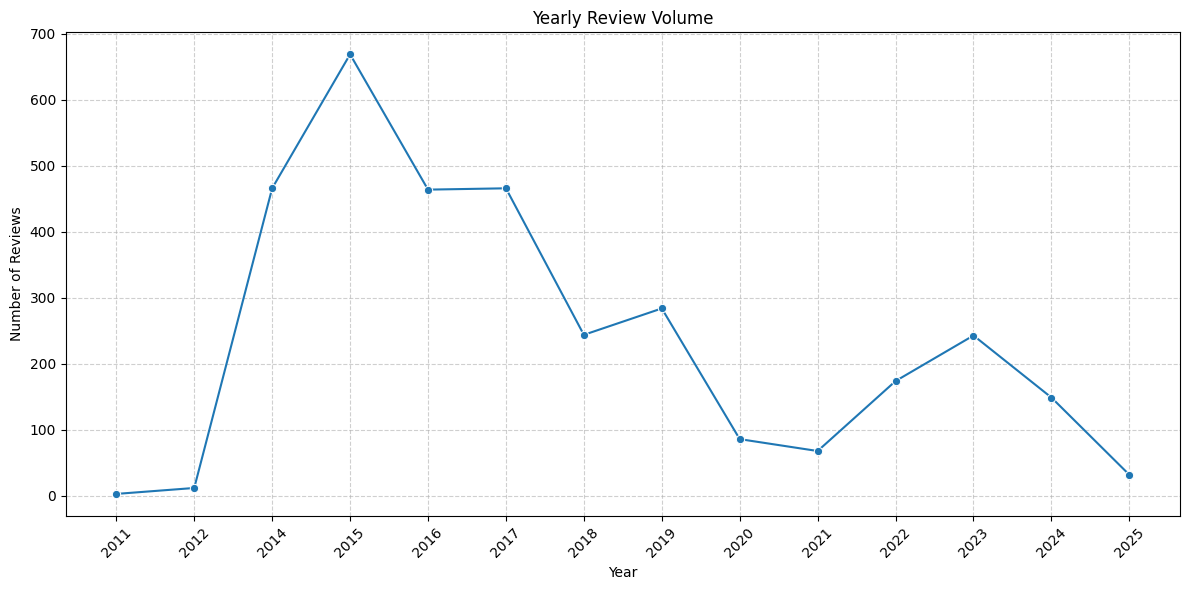

In [22]:
# --- 5. Review Volume over Time ---

df['review_year'] = df['date'].dt.to_period('Y')
yearly_reviews = df.groupby('review_year').size().reset_index(name='review_count')
yearly_reviews['review_year'] = yearly_reviews['review_year'].astype(str) # Convert Period to string for plotting

print("\n--- Review Volume Over Time ---")
print(monthly_reviews)

# Plot: Review Volume Over Time (Line Chart)
plt.figure(figsize=(12, 6))
sns.lineplot(x='review_year', y='review_count', data=yearly_reviews, marker='o')
plt.title('Yearly Review Volume')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


--- 'Would Recommend' Analysis ---
Recommendation Counts:
 recommended
False    2366
True     1575
Name: count, dtype: int64

Recommendation Percentage:
 recommended
False    60.035524
True     39.964476
Name: proportion, dtype: float64


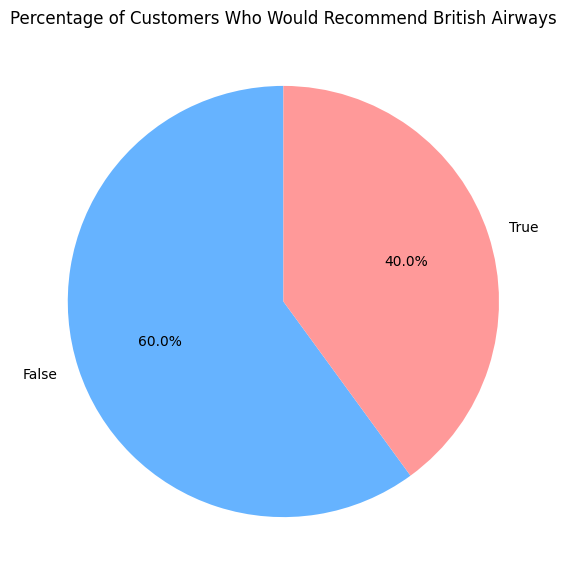

<ipython-input-25-055f1eb77eca>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='recommended', y='rating_out_of_10', data=df, palette='pastel')


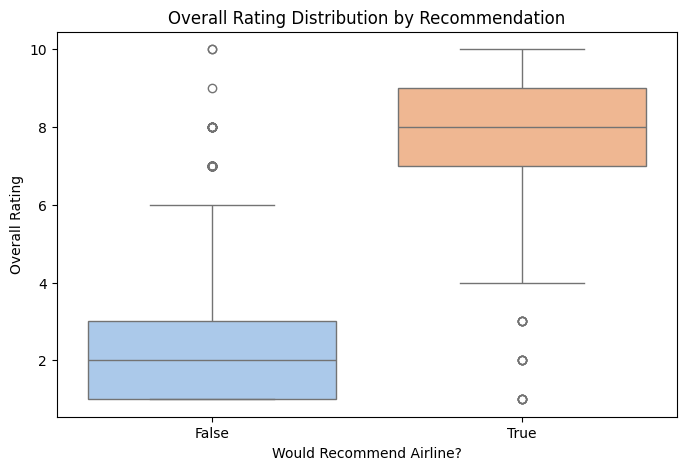

<Figure size 1000x600 with 0 Axes>

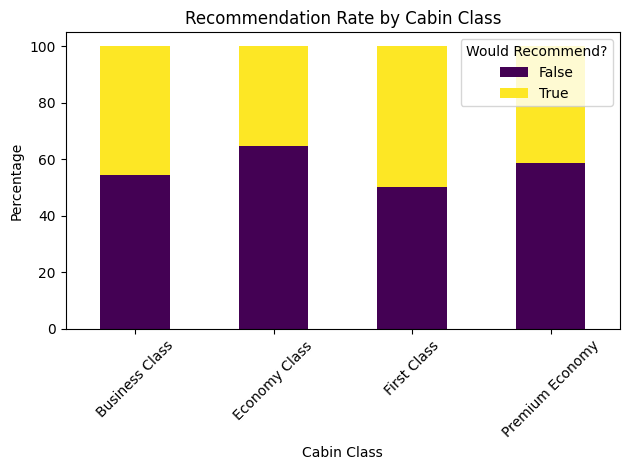


No 'No' recommenders in the sample data to analyze aspect ratings for.


In [25]:
# --- 6. 'Would Recommend' Column Analysis ---

print("\n--- 'Would Recommend' Analysis ---")
recommendation_counts = df['recommended'].value_counts()
recommendation_percentage = df['recommended'].value_counts(normalize=True) * 100

print("Recommendation Counts:\n", recommendation_counts)
print("\nRecommendation Percentage:\n", recommendation_percentage)

# Plot: Recommendation Rate (Pie Chart)
plt.figure(figsize=(7, 7))
recommendation_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Percentage of Customers Who Would Recommend British Airways')
plt.ylabel('')
plt.show()

# Plot: Relationship between 'Would Recommend' and Overall Rating (Box Plot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='recommended', y='rating_out_of_10', data=df, palette='pastel')
plt.title('Overall Rating Distribution by Recommendation')
plt.xlabel('Would Recommend Airline?')
plt.ylabel('Overall Rating')
plt.show()

# Plot: Stacked Bar Chart for 'Would Recommend' by Cabin Class
# Calculate proportions
recommendation_by_class = df.groupby('seat_type')['recommended'].value_counts(normalize=True).unstack().fillna(0) * 100

plt.figure(figsize=(10, 6))
recommendation_by_class.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Recommendation Rate by Cabin Class')
plt.xlabel('Cabin Class')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Would Recommend?')
plt.tight_layout()
plt.show()

# --- Deeper dive: What drives "No" recommendations? ---
# Analyze aspect ratings specifically for 'No' recommenders
no_recommenders_df = df[df['recommended'] == 'false']
if not no_recommenders_df.empty:
    no_recommenders_aspect_means = no_recommenders_df[aspect_columns].mean().sort_values()
    print("\n--- Average Aspect Ratings for 'No' Recommenders ---")
    print(no_recommenders_aspect_means)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=no_recommenders_aspect_means.values, y=no_recommenders_aspect_means.index, palette='Reds_r')
    plt.title('Lowest Rated Aspects for "No" Recommenders')
    plt.xlabel('Average Rating')
    plt.ylabel('Aspect')
    plt.xlim(1, 5)
    plt.show()
else:
    print("\nNo 'No' recommenders in the sample data to analyze aspect ratings for.")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


--- NLTK VADER Sentiment Analysis ---
                                            review_body  \
0     ✅  |   Check-in was slow with only one staff m...   
1     |  Check in was smooth enough. Boarding was ch...   
2     ✅  | Although transferring to this flight thro...   
3     ✅  |   We are extremely grateful to the crew o...   
4     ✅  |   I had an appalling experience with Brit...   
...                                                 ...   
3936  Flew return in CW from LHR to BKK in August 20...   
3937  LHR to HAM. Purser addresses all club passenge...   
3938  My son who had worked for British Airways urge...   
3939  London City-New York JFK via Shannon on A318 b...   
3940  SIN-LHR BA12 B747-436 First Class. Old aircraf...   

                                           vader_scores  vader_compound  \
0     {'neg': 0.105, 'neu': 0.852, 'pos': 0.043, 'co...         -0.6705   
1     {'neg': 0.07, 'neu': 0.919, 'pos': 0.011, 'com...         -0.6848   
2     {'neg': 0.033, 'neu': 

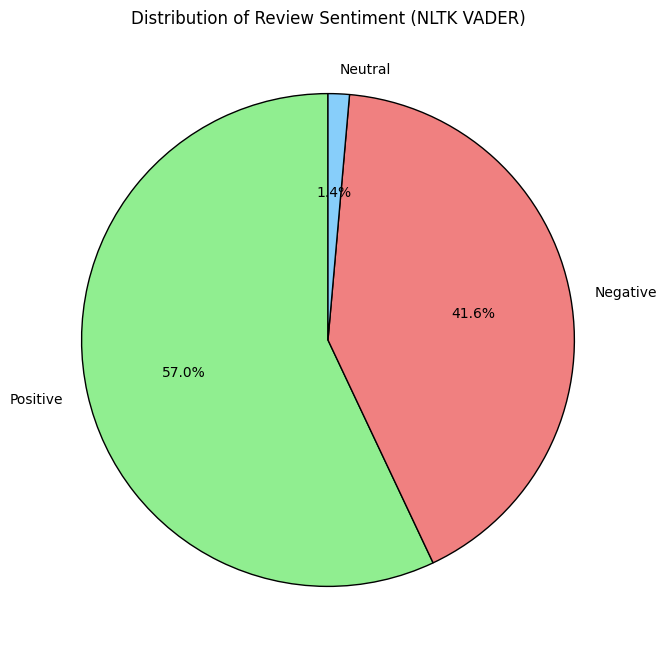

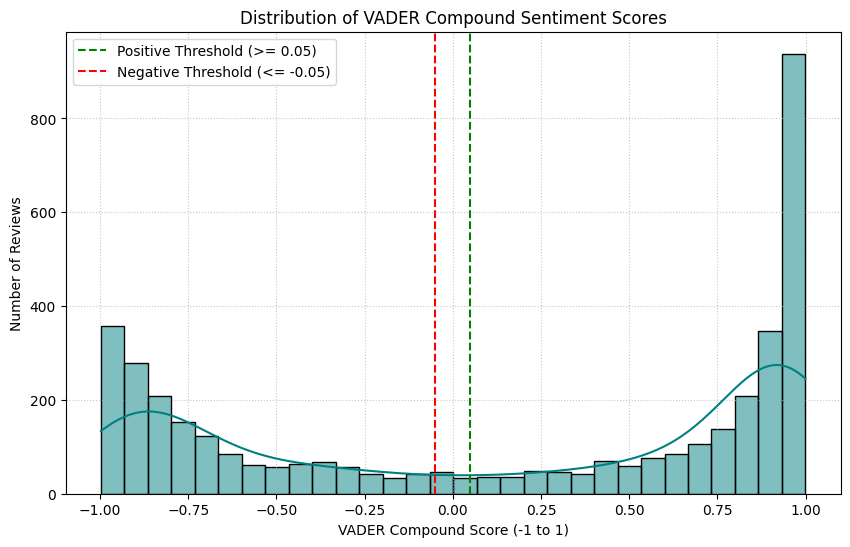


--- Relationship between VADER Sentiment and 'Would Recommend' ---
vader_sentiment_category   Negative   Neutral   Positive
recommended                                             
False                     64.074387  1.986475  33.939138
True                       7.809524  0.507937  91.682540
All                       41.588429  1.395585  57.015986


<Figure size 1000x600 with 0 Axes>

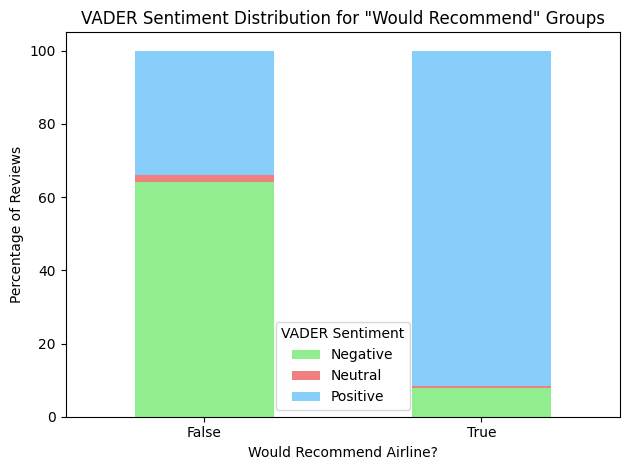

In [28]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('vader_lexicon')

# Download VADER lexicon
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')


print("--- NLTK VADER Sentiment Analysis ---")

# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment scores
def get_vader_scores(text):
    return analyzer.polarity_scores(text)

# Apply the function to the 'review_text' column to get scores
df['vader_scores'] = df['review_body'].apply(get_vader_scores)

# Extract individual scores (neg, neu, pos, compound) into separate columns
df['vader_neg'] = df['vader_scores'].apply(lambda x: x['neg'])
df['vader_neu'] = df['vader_scores'].apply(lambda x: x['neu'])
df['vader_pos'] = df['vader_scores'].apply(lambda x: x['pos'])
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])

# Classify sentiment based on the compound score
def classify_vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment_category'] = df['vader_compound'].apply(classify_vader_sentiment)

# Display some results
print(df[['review_body', 'vader_scores', 'vader_compound', 'vader_sentiment_category']])

print("\nVADER Sentiment Category Distribution:")
print(df['vader_sentiment_category'].value_counts())

# --- Plotting VADER Sentiment Distribution ---

plt.figure(figsize=(8, 8))
sentiment_counts = df['vader_sentiment_category'].value_counts()
colors = {'Positive': 'lightgreen', 'Negative': 'lightcoral', 'Neutral': 'lightskyblue'}
# Ensure consistent order for plotting, e.g., Positive, Negative, Neutral
ordered_categories = ['Positive', 'Negative', 'Neutral']
plot_data = sentiment_counts.reindex(ordered_categories, fill_value=0) # Reindex to ensure all categories are present for consistent coloring

plot_data.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=[colors[cat] for cat in plot_data.index],
    wedgeprops={'edgecolor': 'black'} # Add border for clarity
)
plt.title('Distribution of Review Sentiment (NLTK VADER)')
plt.ylabel('') # Hide the default 'vader_sentiment_category' label
plt.show()

# --- Plotting Compound Score Distribution (Histogram) ---
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_compound'], bins=30, kde=True, color='teal')
plt.title('Distribution of VADER Compound Sentiment Scores')
plt.xlabel('VADER Compound Score (-1 to 1)')
plt.ylabel('Number of Reviews')
plt.axvline(0.05, color='green', linestyle='--', label='Positive Threshold (>= 0.05)')
plt.axvline(-0.05, color='red', linestyle='--', label='Negative Threshold (<= -0.05)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# --- Relationship between VADER Sentiment and 'Would Recommend' ---
print("\n--- Relationship between VADER Sentiment and 'Would Recommend' ---")
cross_tab = pd.crosstab(df['recommended'], df['vader_sentiment_category'], margins=True, normalize='index') * 100
print(cross_tab)

# Plot: Stacked Bar Chart for 'Would Recommend' vs VADER Sentiment
plt.figure(figsize=(10, 6))
cross_tab.drop('All', axis=0).plot(kind='bar', stacked=True, color=[colors[cat] for cat in ordered_categories])
plt.title('VADER Sentiment Distribution for "Would Recommend" Groups')
plt.xlabel('Would Recommend Airline?')
plt.ylabel('Percentage of Reviews')
plt.xticks(rotation=0)
plt.legend(title='VADER Sentiment')
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


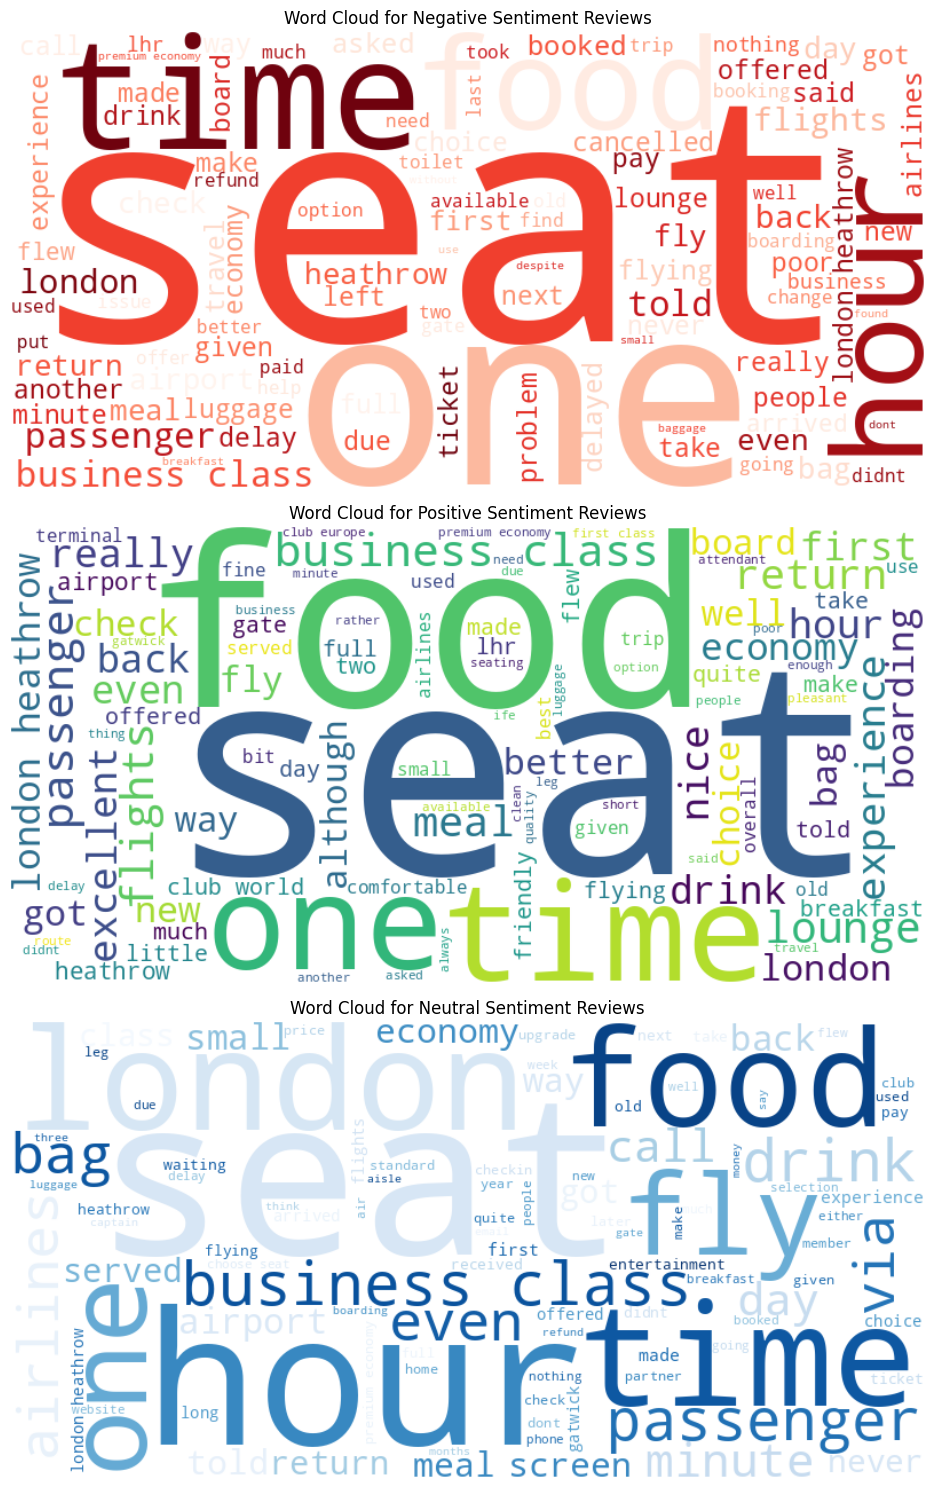

Word clouds generated for each sentiment category.


In [35]:
from wordcloud import WordCloud # This line requires the 'wordcloud' library
from nltk.corpus import stopwords
nltk.download('stopwords')


# --- Text Preprocessing Function for Word Cloud ---
def preprocess_text_for_wordcloud(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    # Add common airline-specific stop words that are not very informative

    airline_stopwords = set(['flight', 'airline', 'airways', 'ba', 'british', 'plane', 'aircraft',
                             'customer', 'service', 'crew', 'staff', 'cabin', 'would', 'still',
                             'could', 'get', 'wasnt', 'were', 'good', 'great', 'bad', 'very'])
    all_stopwords = stop_words.union(airline_stopwords)
    words = [word for word in text.split() if word not in all_stopwords and len(word) > 2] # Filter out short words
    return ' '.join(words)

# Apply preprocessing to your review texts
df['cleaned_review_text'] = df['review_body'].apply(preprocess_text_for_wordcloud)

# --- Generate Word Clouds for each Sentiment Category ---

sentiment_categories = df['vader_sentiment_category'].unique()

plt.figure(figsize=(15, 5 * len(sentiment_categories))) # Adjust figure size dynamically

for i, category in enumerate(sentiment_categories):
    # Filter text for the current sentiment category
    text_for_wordcloud = ' '.join(df[df['vader_sentiment_category'] == category]['cleaned_review_text'])

    if text_for_wordcloud: # Only generate if there's enough text for the category
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis' if category == 'Positive' else ('Reds' if category == 'Negative' else 'Blues'), # Color by sentiment
            max_words=100, # Limit the number of words shown
            min_font_size=10,
            contour_width=1,  # Add a slight contour for definition
            contour_color='steelblue'
        ).generate(text_for_wordcloud)

        plt.subplot(len(sentiment_categories), 1, i + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {category} Sentiment Reviews')
    else:
        # Handle cases where a sentiment category might have no reviews
        plt.subplot(len(sentiment_categories), 1, i + 1)
        plt.axis('off')
        plt.title(f'No sufficient data for {category} Sentiment Word Cloud')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

print("Word clouds generated for each sentiment category.")